In [15]:
import numpy as np
import scipy
from scipy.optimize import curve_fit
import scipy.interpolate
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.cluster import dbscan
import matplotlib.pyplot as plt
import gudhi
import os
import glob
import matplotlib.colors as colors

In [16]:
plt.rcParams['figure.dpi'] = 400
plt.rcParams['savefig.dpi'] = 600
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.sans-serif'] = ['Verdana']
plt.rcParams['legend.edgecolor'] = '0.0'
# plt.rcParams['figure.figsize'] = 6,5
plt.rcParams.update({'figure.autolayout': True})
plt.rc('text', usetex=True)
green1='#238E68'
green2='#32CC99' 
green3='#76EEC6'
blue1='#00688B'
blue2='#0099CC'
blue3='#87CEEB'
orange1='#DD7500'
orange2='#FF9912'
orange3='#FFCC11'

## Create and save persistence data (only needs to be done once)

In [17]:
# # Get list of files with particular temp
# flist=np.sort(glob.glob("*2d_square*/0.0/*.txt"))

In [18]:
# for f in flist:
#     data = np.loadtxt(f, dtype=int)
#     alpha_complex=gudhi.AlphaComplex(data)
#     simplex_tree=alpha_complex.create_simplex_tree()
#     PD=simplex_tree.persistence()
#     PD0=[]
#     PD1=[]
#     for elm in PD:
#         if elm[0]==1:
#             PD1.append((elm[1][0],elm[1][1]-elm[1][0]))
#         else:
#             if elm[1][1]!=float('inf'):
#                 PD0.append((elm[1][0],elm[1][1]-elm[1][0]))
#     PD0=np.round(PD0,decimals=5)
#     PD1=np.round(PD1,decimals=5)
#     loc,counts=np.unique(PD0,axis=0,return_counts=True)
#     toSave=np.array([[loc[i][0],loc[i][1],counts[i]] for i in np.arange(len(counts))])
#     np.savetxt(f[:len(f)-4]+"PD0.dat",toSave)
#     loc,counts=np.unique(PD1,axis=0,return_counts=True)
#     toSave=np.array([[loc[i][0],loc[i][1],counts[i]] for i in np.arange(len(counts))])
#     np.savetxt(f[:len(f)-4]+"PD1.dat",toSave)
#     print(f)

## Display sample spin configuration
A bit of a hack, since the spins live on the edges of the cubical lattice. Create a mask using the spins' physical locations.

In [19]:
f = np.sort(glob.glob("*2d_square*/1.0/*.txt"))
test = np.loadtxt(f[400])

x, y = np.meshgrid(np.arange(2*50), np.arange(2*50))

z = np.ones([100,100])

mask = np.zeros_like(z)
for s in test:
    i, j = 2*s
    mask[int(i)][int(j)] = 1

z = np.ma.array(z, mask=mask)

fig = plt.figure(figsize=(20,20))
# fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)

cs = ax.contourf(x, y, z, corner_mask = True, cmap='Greys', vmin=0)
ax.set_aspect('equal')
# ax.axis('off')
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
plt.show()

## Load persistence diagram data
Persistence diagram data has previously been saved as (birth, persistence, frequency). Load all such data and extract the corresponding temperature from the filepath.

Only H1 data are loaded currently (0-cycles all have birth=0).

In [20]:
# Get all H1 data files
fPD1list=np.sort(glob.glob("*2d_square*/*/*PD1.dat"))
TPD1list=[]

# Extract temps
for f in fPD1list:
    TPD1list.append(float(f[33:36]))

TPD1list = np.array(TPD1list)
tempsUnique = np.unique(TPD1list)

# Load data
PD1data = np.array([np.loadtxt(f) for f in fPD1list])

Display counts of how many runs have been loaded for each temperature.

In [21]:
simsData = np.transpose(np.unique(TPD1list, return_counts=True))

for i in range(len(simsData)):
    print("%ix \tT = %.2f" % (simsData[i][1], simsData[i][0]))

711x 	T = 0.00
745x 	T = 0.10
731x 	T = 0.20
721x 	T = 0.30
744x 	T = 0.40
731x 	T = 0.50
717x 	T = 0.60
756x 	T = 0.70
809x 	T = 0.80
844x 	T = 0.90
894x 	T = 1.00
893x 	T = 1.10
918x 	T = 1.20
924x 	T = 1.30
950x 	T = 1.40
945x 	T = 1.50
948x 	T = 1.60
949x 	T = 1.70
963x 	T = 1.80
956x 	T = 1.90
948x 	T = 2.00
961x 	T = 2.10
965x 	T = 2.20
972x 	T = 2.30
960x 	T = 2.40
959x 	T = 2.50
959x 	T = 2.60
967x 	T = 2.70
969x 	T = 2.80
970x 	T = 2.90
974x 	T = 3.00
967x 	T = 3.10
970x 	T = 3.20
971x 	T = 3.30
989x 	T = 3.40
978x 	T = 3.50
976x 	T = 3.60
974x 	T = 3.70
962x 	T = 3.80
970x 	T = 3.90
981x 	T = 4.00


## Computing persistence images
PIs are constructed from persistence diagram data, which has been saved/loaded as (birth, persistence, frequency). With a lattice many points in the persistence diagram occur with precisely the same birth/death, so saving their frequency helps with efficiency.

A weight log(1+p) is used to kill low-persistence features/emphasize long-lived features which are more "real". Having the weight vanish for p=0 is part of the stability theorems.

In [22]:
# pdlocnumI gives index of persistence diagram in loaded data
# bounds should be a list [bmin,bmax,pmin,pmax]
# bins should be a list [bbins, pbins]
# stdev gives width of gaussians

def PerIm(pdlocnumI,bounds,bins,stdev,res=1000):
    if pdlocnumI % 5000 == 0:
        print("%6.2f %%" % (100 * pdlocnumI / len(PD1data)))
        
    pdlocnum = PD1data[pdlocnumI]
    
    x = np.linspace(bounds[0], bounds[1], res)
    y = np.linspace(bounds[2], bounds[3], res)
    xx, yy = np.meshgrid(x, y, sparse=True)
    z=np.zeros([res,res])
    
    for i in np.arange(len(pdlocnum)):
        birth = pdlocnum[i][0]
        persistence = pdlocnum[i][1]
        weight = np.log(1 + persistence)
        freq = pdlocnum[i][2]
        z += freq * weight * np.exp((-0.5*(xx-birth)**2-0.5*(yy-persistence)**2)*stdev**-2)
        
    return z.reshape(bins[0], res//bins[0], bins[1], res//bins[1]).sum(3).sum(1)

In [23]:
# Create persistence images
bounds=[0,2.5,0,2.5]
bins=[20,20]
res=bins[0]*10
sigma = 0.15

imgs1=[PerIm(p, bounds, bins, sigma, res) for p in np.arange(len(PD1data))]
print("100.00 %\n\nDONE")

  0.00 %
 13.44 %
 26.89 %
 40.33 %
 53.78 %
 67.22 %
 80.66 %
 94.11 %
100.00 %

DONE


Flatten persistence images into 1D arrays and normalize according to the L1 norm (so they are probability distributions).

In [24]:
# Flatten persistence images into 1D vectors
imgs1_array = np.array([img.flatten() for img in imgs1])

# Normalize according to L1 norm, i.e. make 'probability density functions'
imgs1_array = 100*preprocessing.normalize(imgs1_array, norm='l1')

## An example

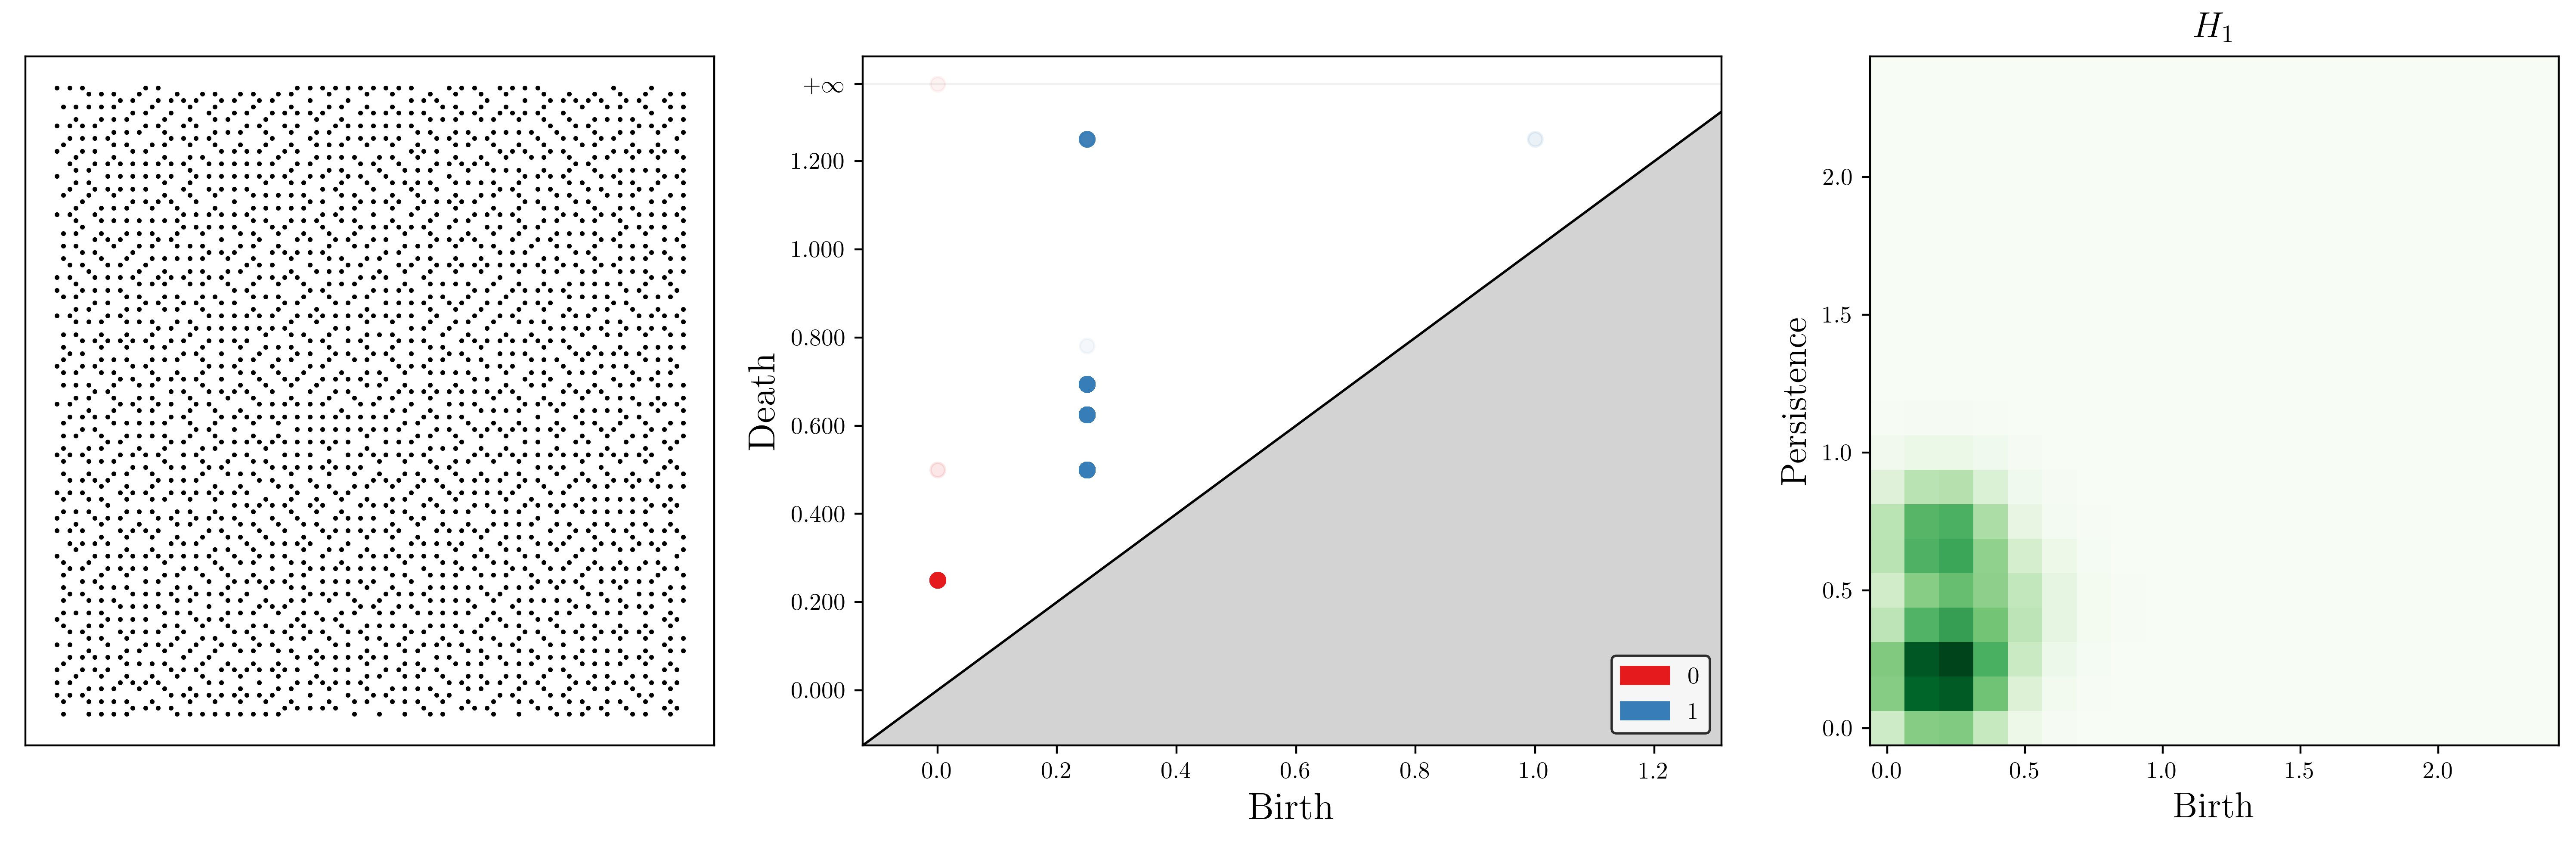

In [46]:
# Pick a single sample of a given temp
sampleSpinsFile = np.sort(glob.glob("*2d_square*/0.5/*.txt"))[200]
sampleSpins = np.loadtxt(sampleSpinsFile)

# Find where it lives in the file list
whr = np.where([f[-17:-7]==sampleSpinsFile[-14:-4] and f[-21:-18]==sampleSpinsFile[-18:-15] for f in fPD1list])[0][0]



# Get persistence diagram
alpha_complex = gudhi.AlphaComplex(sampleSpins)
simplex_tree = alpha_complex.create_simplex_tree()
samplePD = simplex_tree.persistence()

# Get persistence image
samplePI = imgs1[whr]


fig, axes = plt.subplots(1, 3, figsize=(16,5))

axes[0].scatter(sampleSpins[:,0], sampleSpins[:,1], c='k', s=1)
axes[0].set_aspect('equal')
axes[0].set_xticks([])
axes[0].set_yticks([])

gudhi.plot_persistence_diagram(samplePD, alpha=0.05, legend=True, axes=axes[1])
axes[1].set_title('')

axes[2].imshow(samplePI, origin='lower', cmap='Greens')
axes[2].set_title('$H_1$', fontsize=15)
axes[2].set_aspect('equal')
plt.xticks(range(0, 20, 4), labels=np.arange(0, 2.5, 0.5))
plt.yticks(range(0, 20, 4), labels=np.arange(0, 2.5, 0.5))
plt.xlabel('Birth', fontsize=15)
plt.ylabel('Persistence', fontsize=15)

plt.savefig('temp_SI.png')

plt.show()

## Phase classification with logistic regression
Training is done only on data with temperature 'far' from the anticipated critical temperature.

In [31]:
belowTemp = 0.55
aboveTemp = 3.45
far_indices = np.where((TPD1list < belowTemp) | (TPD1list > aboveTemp))[0]
imgs1_far = imgs1_array[far_indices]
temps_far = TPD1list[far_indices]

# 0 for low-temp, 1 for high-temp
labels = [int(t > 2) for t in temps_far]

X_train, X_test, y_train, y_test, T_train, T_test = train_test_split(imgs1_far, labels, temps_far, test_size=0.25)

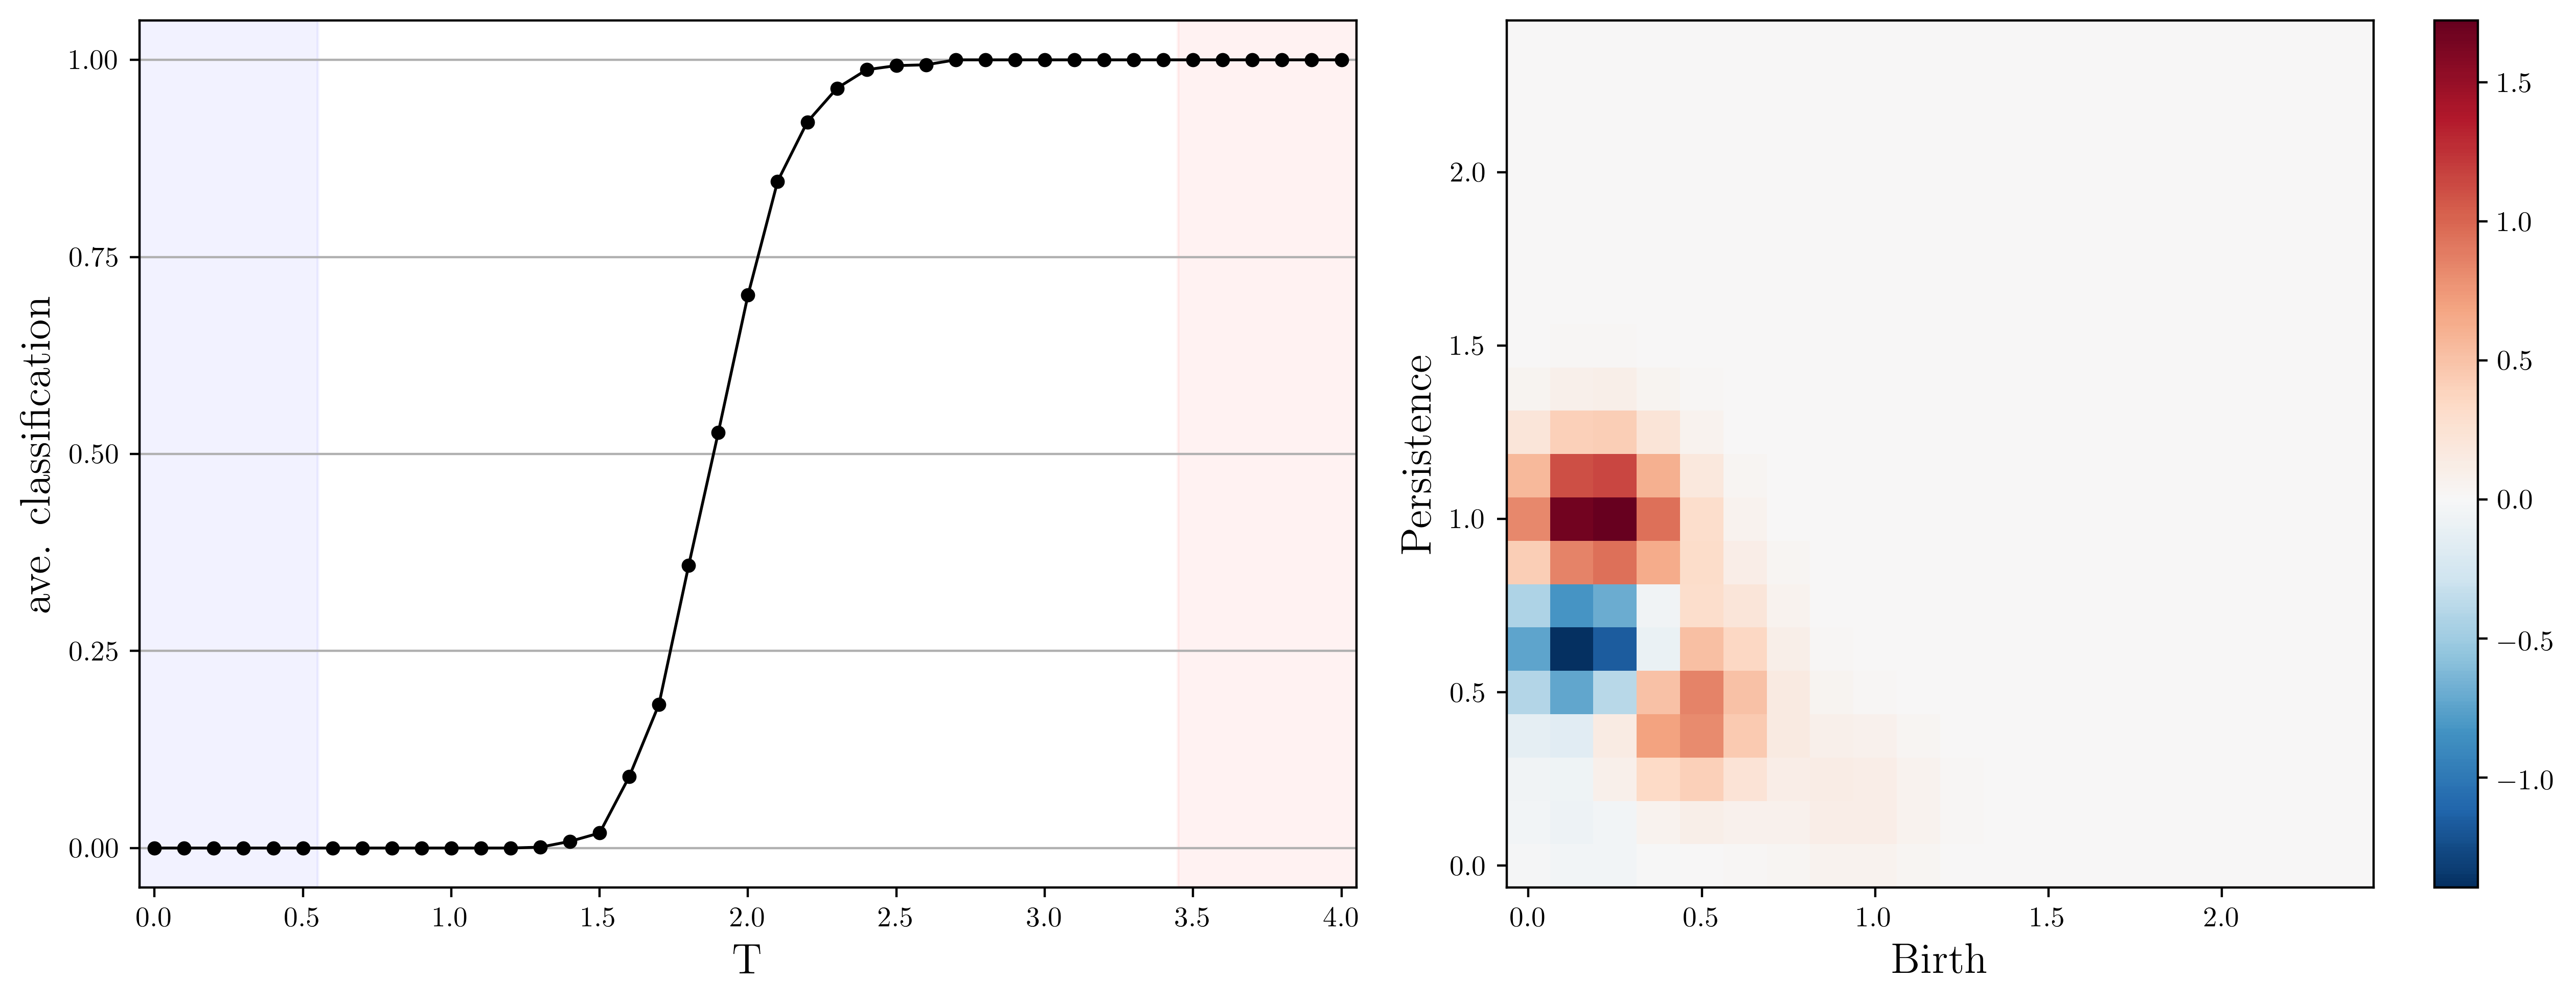

50% cross-over temp: 1.883901705115346


In [42]:
logreg = LogisticRegression(C=0.1, solver='liblinear', penalty='l2')
logreg.fit(X_train, y_train)

inverse_image = np.copy(logreg.coef_).reshape((bins[0],bins[1]))

fig, axes = plt.subplots(1, 2, figsize=(13,5))

# maxAbsValue = max(abs(logreg.coef_[0]))
# norm = colors.DivergingNorm(vmin = -maxAbsValue, vcenter = 0, vmax = maxAbsValue)
norm = colors.DivergingNorm(vcenter = 0)

cs = axes[1].imshow(inverse_image, origin='lower', cmap='RdBu_r', norm=norm)
cbar = fig.colorbar(cs)
plt.xticks(range(0, 20, 4), labels=np.arange(0, 2.5, 0.5))
plt.yticks(range(0, 20, 4), labels=np.arange(0, 2.5, 0.5))
plt.xlabel('Birth', fontsize=15)
plt.ylabel('Persistence', fontsize=15)

pred = logreg.predict(imgs1_array)
avg = np.zeros(len(tempsUnique))
for i in np.arange(len(tempsUnique)):
    avg[i] = np.mean(pred[np.where(TPD1list==tempsUnique[i])[0]])

    
# Plot regions of training data
axes[0].axvspan(-0.05, belowTemp, color='blue', alpha=0.05)
axes[0].axvspan(aboveTemp, 4.05, color='red', alpha=0.05)

# Plot average classification
axes[0].plot(tempsUnique, avg, '-o', c='black', lw=1, ms=4)


axes[0].set_xlim([-0.05, 4.05])
axes[0].set_ylim([-0.05, 1.05])
axes[0].set_yticks(np.arange(0, 1.01, step=0.25))
axes[0].grid(which='major', axis='y')
axes[0].set_xlabel('T', fontsize=15)
axes[0].set_ylabel('ave. classification', fontsize=15)

plt.savefig('temp_SI.png')

plt.show()

# Identify cross-over temp as critical temp
print('50% cross-over temp:', scipy.interpolate.interp1d(avg, tempsUnique)(0.5))

## Visualizing persistence images with PCA

In [19]:
pca = PCA(n_components=2)
X_r = pca.fit(imgs1_array).transform(imgs1_array)
print(pca.explained_variance_ratio_)

[0.78032927 0.14560473]


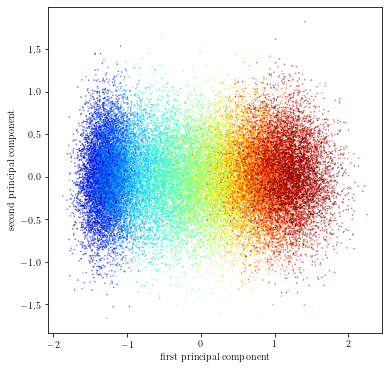

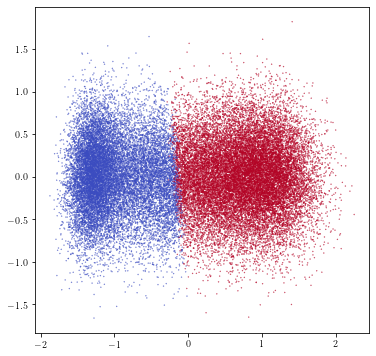

In [29]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
cmap = plt.cm.jet
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(0,4,17)
norm = colors.BoundaryNorm(bounds, cmap.N)
scat = ax.scatter(X_r[:,0], X_r[:,1], c=TPD1list, s=0.1, cmap=cmap, norm=norm)
# cbar = fig.colorbar(scat)
plt.xlabel('first principal component')
plt.ylabel('second principal component')
plt.show()

fig, ax = plt.subplots(1,1, figsize=(6,6))
scat = ax.scatter(X_r[:,0], X_r[:,1], c=pred, s=0.1, cmap='coolwarm')
plt.show()